<div class="alert alert-block alert-warning">
<b>Note:</b> In this notebook are placeholders/proxies on purpose. They will be replaced in later stages of BioFairNet with ISO 14075:2024 aligned indicators and propoer LCA hooks.
</div>

### Imports, config and paths

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np

repo_root = Path.cwd().parents[0]
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from helper.utils import find_repo_root, load_pipeline_config, save_run_log, ensure_dir

repo_root = find_repo_root()
cfg = load_pipeline_config(repo_root)

processed_dir = repo_root / cfg["paths"]["processed_dir"]
results_dir   = repo_root / cfg["paths"]["results_dir"]
models_dir    = repo_root / cfg["paths"]["models_dir"]

ensure_dir(results_dir)

print("processed_dir:", processed_dir)
print("results_dir:", results_dir)
print("models_dir:", models_dir)

processed_dir: /home/097e80f6-6687-4e65-aab6-9abf7b887006/GreenInformationFactory_Prototype/data/processed
results_dir: /home/097e80f6-6687-4e65-aab6-9abf7b887006/GreenInformationFactory_Prototype/data/results
models_dir: /home/097e80f6-6687-4e65-aab6-9abf7b887006/GreenInformationFactory_Prototype/notebooks/models


### Load the best model bundle from Notebook 03

In [2]:
import pickle

bundle_path = models_dir / "all_models.pkl"
assert bundle_path.exists(), f"Missing model bundle: {bundle_path} (run 03_train_optimize first)"

with open(bundle_path, "rb") as f:
    bundle = pickle.load(f)

best_name  = bundle["best_model_name"]
best_model = bundle["best_model"]
res_df     = bundle["comparison"]

print("✅ Loaded best model:", best_name)
res_df.head()


✅ Loaded best model: rf


,model,rmse_test,r2_test,rmse_val,r2_val,fit_seconds,best_params
0,rf,0.021830,0.999997,0.024373,0.999996,63.27,"{'max_depth': None, 'min_samples_split': 2, 'n..."
1,gbr,0.030177,0.999993,0.031743,0.999993,33.43,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est..."
2,mlp,0.112122,0.999910,0.102355,0.999929,132.42,"{'model__alpha': 0.001, 'model__hidden_layer_s..."
3,svr,0.121916,0.999893,0.114221,0.999912,49.22,"{'model__C': 10, 'model__epsilon': 0.1, 'model..."
4,linreg,1.910712,0.973814,1.935283,0.974742,0.03,{}


### Load processed splits

In [3]:
def load_split(split_name: str):
    split_dir = processed_dir / split_name
    assert split_dir.exists(), f"Split folder not found: {split_dir}"

    # common filename variants
    x_candidates = ["X_train.csv","X_test.csv","X_val.csv","X_validation.csv",
                    "BioFairNet_Pilot1_Testrun_Train_in.csv","BioFairNet_Pilot1_Testrun_Test_in.csv"]
    y_candidates = ["y_train.csv","y_test.csv","y_val.csv","y_validation.csv",
                    "BioFairNet_Pilot1_Testrun_Train_out.csv","BioFairNet_Pilot1_Testrun_Test_out.csv"]

    x_path = next((split_dir / f for f in x_candidates if (split_dir / f).exists()), None)
    y_path = next((split_dir / f for f in y_candidates if (split_dir / f).exists()), None)

    if x_path is None or y_path is None:
        raise FileNotFoundError(
            f"Could not find X/y files in {split_dir}. Found: {[p.name for p in split_dir.glob('*.csv')]}"
        )

    X = pd.read_csv(x_path)
    y = pd.read_csv(y_path).squeeze("columns")
    return X, y, x_path.name, y_path.name

X_test, y_test, xtn, ytn = load_split("Test")
val_folder = "Validation" if (processed_dir / "Validation").exists() else "Val"
X_val,  y_val,  xvn, yvn = load_split(val_folder)

print("✅ Test loaded:", xtn, ytn, X_test.shape)
print("✅ Val  loaded:", xvn, yvn, X_val.shape)


✅ Test loaded: X_test.csv y_test.csv (1476, 3)
✅ Val  loaded: X_val.csv y_val.csv (1845, 3)


In [4]:
yhat_test = best_model.predict(X_test)
yhat_val  = best_model.predict(X_val)

pred_test = X_test.copy()
pred_test["y_true"] = y_test.to_numpy()
pred_test["y_pred"] = yhat_test

pred_val = X_val.copy()
pred_val["y_true"] = y_val.to_numpy()
pred_val["y_pred"] = yhat_val

pred_test.head()

,time_s,Temperature (°C),Stiring,y_true,y_pred
0,2185.0,250.6,0.1,39.1,39.1284
1,2806.0,247.7,0.1,37.4,37.3986
2,202.0,119.0,0.1,0.9,0.9000
3,4651.0,250.0,0.1,39.0,39.0000
4,1503.0,225.2,0.1,26.1,26.1356


### Fixed proxy

In [9]:
from helper.sustainability_metrics import sustainability_v1

test_metrics, drivers_test = sustainability_v1(pred_test)
val_metrics,  drivers_val  = sustainability_v1(pred_val)

print("Drivers used (test):", drivers_test)
print("Drivers used (val):", drivers_val)

Drivers used (test): {'temperature': None, 'time': 'time_s', 'stirring': 'Stiring'}
Drivers used (val): {'temperature': None, 'time': 'time_s', 'stirring': 'Stiring'}


### PCA-based proxy

In [5]:
from helper.sustainability_metrics import (
    sustainability_v1,
    sustainability_pca_energy_index
)

In [6]:
# Apply PCA-based proxy
test_metrics_pca, pca_info_test = sustainability_pca_energy_index(pred_test)
val_metrics_pca,  pca_info_val  = sustainability_pca_energy_index(pred_val)

print("PCA drivers:", pca_info_test["used_columns"])
print("Explained variance (PC1):", pca_info_test["explained_variance_ratio"])

PCA drivers: ['time_s']
Explained variance (PC1): None


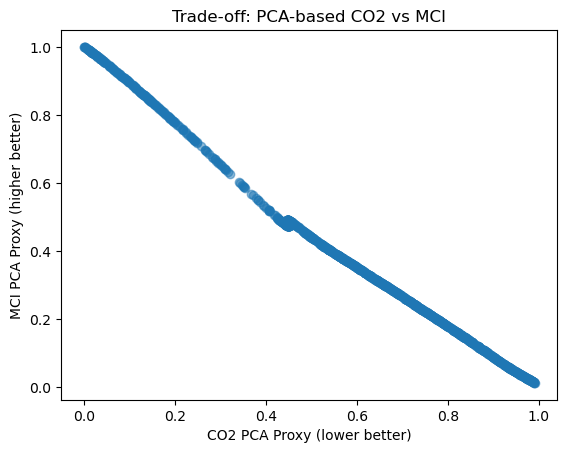

In [7]:
#Save Results
test_metrics_pca.to_csv(results_dir / f"sustainability_pca_test_{best_name}.csv", index=False)
val_metrics_pca.to_csv(results_dir / f"sustainability_pca_val_{best_name}.csv", index=False)

#Plot PCA tradeoff

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(test_metrics_pca["co2_pca_proxy"], test_metrics_pca["mci_pca_proxy"], alpha=0.5)
plt.xlabel("CO2 PCA Proxy (lower better)")
plt.ylabel("MCI PCA Proxy (higher better)")
plt.title("Trade-off: PCA-based CO2 vs MCI")
plt.show()

Use the assumptions-based proxy for sustainability assessment

In [8]:
from helper.sustainability_metrics import sustainability_from_assumptions

assumptions_path = repo_root / "metadata" / "sustainability_assumptions_v1.json"

test_assumed, info_assumed_test = sustainability_from_assumptions(pred_test, assumptions_path)
val_assumed,  info_assumed_val  = sustainability_from_assumptions(pred_val,  assumptions_path)

print("Resolved drivers:", info_assumed_test["resolved_driver_columns"])
test_assumed[["y_pred", "energy_assumed", "co2_assumed", "mci_assumed"]].head()


Resolved drivers: {'time': 'time_s', 'temperature': None, 'stirring': 'Stiring'}


,y_pred,energy_assumed,co2_assumed,mci_assumed
0,39.1284,0.236596,0.449571,0.479437
1,37.3986,0.303994,0.483968,0.456041
2,0.9000,0.021381,0.016444,0.985201
3,39.0000,0.504233,0.635968,0.320120
4,26.1356,0.162579,0.301753,0.651856


# Comparison

### Unified Comparison Table

In [15]:
def build_comparison_df(base_df, v1_df, pca_df, assumed_df):
    n = min(len(v1_df), len(pca_df), len(assumed_df))
    return pd.DataFrame({
        "y_pred": base_df["y_pred"].to_numpy()[:n],
        "co2_v1": v1_df["co2_proxy"].to_numpy()[:n],
        "co2_pca": pca_df["co2_pca_proxy"].to_numpy()[:n],
        "co2_assumed": assumed_df["co2_assumed"].to_numpy()[:n],
        "mci_v1": v1_df["mci_proxy"].to_numpy()[:n],
        "mci_pca": pca_df["mci_pca_proxy"].to_numpy()[:n],
        "mci_assumed": assumed_df["mci_assumed"].to_numpy()[:n],
    })


comp_test = build_comparison_df(pred_test, test_metrics, test_metrics_pca, test_assumed)
comp_val  = build_comparison_df(pred_val,  val_metrics,  val_metrics_pca,  val_assumed)

comp_test["split"] = "test"
comp_val["split"]  = "validation"

comp_all = pd.concat([comp_test, comp_val], ignore_index=True)
comp_all.head()

,y_pred,co2_v1,co2_pca,co2_assumed,mci_v1,mci_pca,mci_assumed,split
0,39.1284,0.350201,0.449571,0.449571,0.564612,0.479437,0.479437,test
1,37.3986,0.356290,0.483968,0.483968,0.565479,0.456041,0.456041,test
2,0.9000,0.007464,0.016444,0.016444,0.992898,0.985201,0.985201,test
3,39.0000,0.424190,0.635968,0.635968,0.501644,0.320120,0.320120,test
4,26.1356,0.233470,0.301753,0.301753,0.710384,0.651856,0.651856,test


In [16]:
cmp_all_path = results_dir / f"sustainability_method_comparison_test_vs_val_{best_name}.csv"
comp_all.to_csv(cmp_all_path, index=False)
print("✅ Saved:", cmp_all_path.relative_to(repo_root))

✅ Saved: data/results/sustainability_method_comparison_test_vs_val_rf.csv


### Trade-off plot: Test vs. Validation (CO₂ vs MCI)

This answears the question "does validation behave similarly to test?".

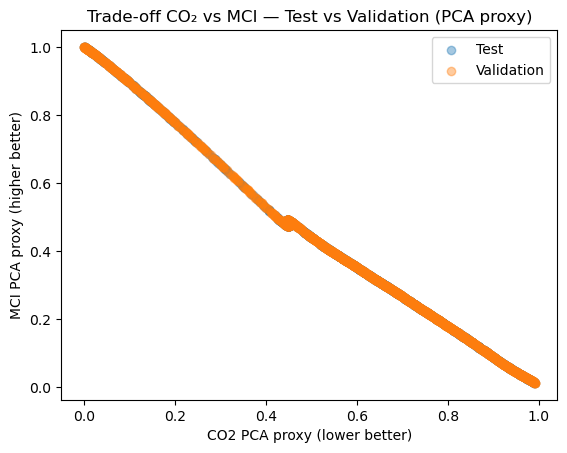

✅ Saved: data/results/tradeoff_test_vs_validation_pca_rf.png


In [17]:
plt.figure()
plt.title("Trade-off CO₂ vs MCI — Test vs Validation (PCA proxy)")
plt.xlabel("CO2 PCA proxy (lower better)")
plt.ylabel("MCI PCA proxy (higher better)")

plt.scatter(comp_test["co2_pca"], comp_test["mci_pca"], alpha=0.4, label="Test")
plt.scatter(comp_val["co2_pca"],  comp_val["mci_pca"],  alpha=0.4, label="Validation")

plt.legend()
tradeoff_tv_path = results_dir / f"tradeoff_test_vs_validation_pca_{best_name}.png"
plt.savefig(tradeoff_tv_path, dpi=200, bbox_inches="tight")
plt.show()

print("✅ Saved:", tradeoff_tv_path.relative_to(repo_root))

### Distribution shift (CO₂ and MCI)

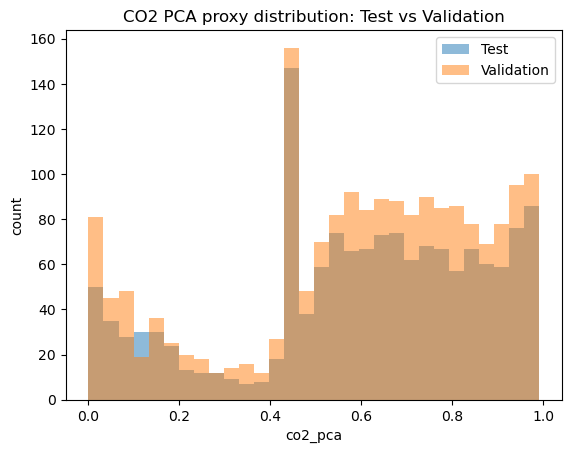

✅ Saved: data/results/dist_co2_test_vs_val_rf.png


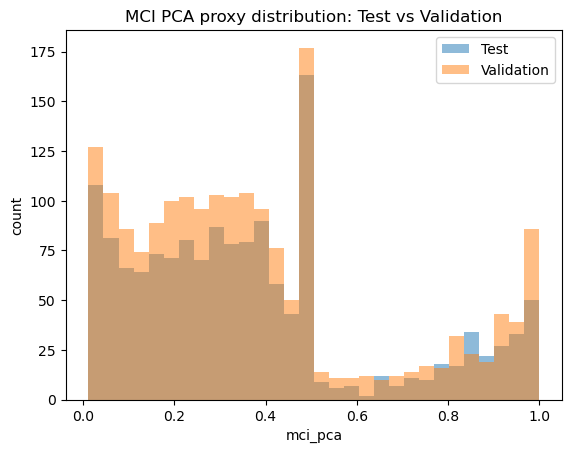

✅ Saved: data/results/dist_mci_test_vs_val_rf.png


In [18]:
def compare_distribution(test, val, col, title, fname):
    plt.figure()
    plt.hist(test[col], bins=30, alpha=0.5, label="Test")
    plt.hist(val[col], bins=30, alpha=0.5, label="Validation")
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend()
    out_path = results_dir / fname
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", out_path.relative_to(repo_root))


compare_distribution(comp_test, comp_val, "co2_pca",
    "CO2 PCA proxy distribution: Test vs Validation",
    f"dist_co2_test_vs_val_{best_name}.png")

compare_distribution(comp_test, comp_val, "mci_pca",
    "MCI PCA proxy distribution: Test vs Validation",
    f"dist_mci_test_vs_val_{best_name}.png")


### Quantitative divergence metrics

This provides a numeric argument for "data lake sufficiency"

In [19]:
summary_tv = pd.DataFrame([
    {
        "metric": "co2_pca_mean_diff",
        "value": float(comp_test["co2_pca"].mean() - comp_val["co2_pca"].mean())
    },
    {
        "metric": "mci_pca_mean_diff",
        "value": float(comp_test["mci_pca"].mean() - comp_val["mci_pca"].mean())
    },
    {
        "metric": "co2_pca_std_ratio",
        "value": float(comp_val["co2_pca"].std() / (comp_test["co2_pca"].std() + 1e-9))
    },
    {
        "metric": "mci_pca_std_ratio",
        "value": float(comp_val["mci_pca"].std() / (comp_test["mci_pca"].std() + 1e-9))
    }
])

summary_tv

,metric,value
0,co2_pca_mean_diff,0.004153
1,mci_pca_mean_diff,-0.004848
2,co2_pca_std_ratio,1.017931
3,mci_pca_std_ratio,1.021843


In [20]:
tv_summary_path = results_dir / f"test_vs_validation_shift_summary_{best_name}.csv"
summary_tv.to_csv(tv_summary_path, index=False)
print("✅ Saved:", tv_summary_path.relative_to(repo_root))

✅ Saved: data/results/test_vs_validation_shift_summary_rf.csv


### Correlation Heatmap

This provides a method agreement view for robustness versus transparency narratives:

- If correlations are high: methods are consistent; proxies are robust.

- If correlations differ: assumption-driven vs data-driven differences are expected and transparent; motivates future ISO 14075 metrics.

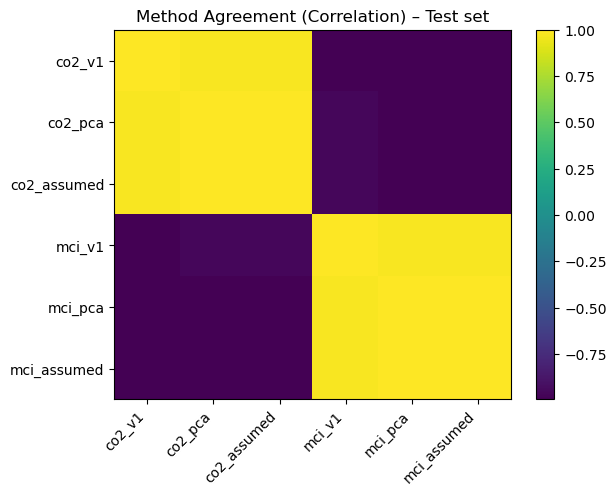

✅ Saved: data/results/compare_methods_correlation_test_rf.png


In [14]:
import matplotlib.pyplot as plt

corr = comp_test[[
    "co2_v1","co2_pca","co2_assumed",
    "mci_v1","mci_pca","mci_assumed"
]].corr()

plt.figure()
plt.title("Method Agreement (Correlation) – Test set")
plt.imshow(corr.to_numpy(), aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
corr_path = results_dir / f"compare_methods_correlation_test_{best_name}.png"
plt.savefig(corr_path, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Saved:", corr_path.relative_to(repo_root))


<div class="alert alert-block alert-info">
<b>Note:</b> In this notebook are placeholders/proxies on purpose. They will be replaced in later stages of BioFairNet with ISO 14075:2024 aligned indicators and propoer LCA hooks.
</div>

### Comparison plot (CO₂ + MCI) across methods

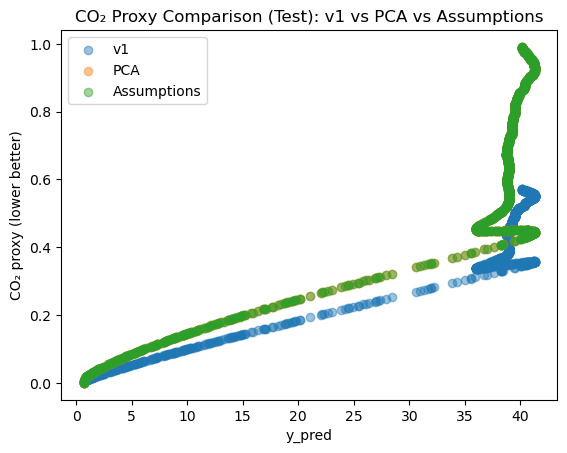

✅ Saved: data/results/compare_co2_methods_test_rf.png


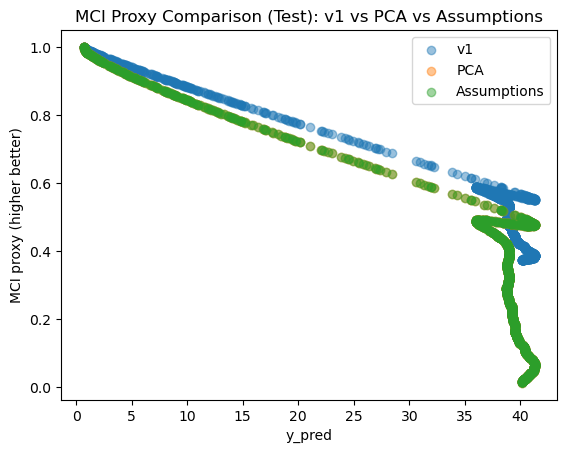

✅ Saved: data/results/compare_mci_methods_test_rf.png


In [12]:
import matplotlib.pyplot as plt

# ---- CO2 comparison (scatter vs y_pred) ----
plt.figure()
plt.title("CO₂ Proxy Comparison (Test): v1 vs PCA vs Assumptions")
plt.xlabel("y_pred")
plt.ylabel("CO₂ proxy (lower better)")
plt.scatter(comp_test["y_pred"], comp_test["co2_v1"], alpha=0.45, label="v1")
plt.scatter(comp_test["y_pred"], comp_test["co2_pca"], alpha=0.45, label="PCA")
plt.scatter(comp_test["y_pred"], comp_test["co2_assumed"], alpha=0.45, label="Assumptions")
plt.legend()
co2_cmp_path = results_dir / f"compare_co2_methods_test_{best_name}.png"
plt.savefig(co2_cmp_path, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Saved:", co2_cmp_path.relative_to(repo_root))

# ---- MCI comparison (scatter vs y_pred) ----
plt.figure()
plt.title("MCI Proxy Comparison (Test): v1 vs PCA vs Assumptions")
plt.xlabel("y_pred")
plt.ylabel("MCI proxy (higher better)")
plt.scatter(comp_test["y_pred"], comp_test["mci_v1"], alpha=0.45, label="v1")
plt.scatter(comp_test["y_pred"], comp_test["mci_pca"], alpha=0.45, label="PCA")
plt.scatter(comp_test["y_pred"], comp_test["mci_assumed"], alpha=0.45, label="Assumptions")
plt.legend()
mci_cmp_path = results_dir / f"compare_mci_methods_test_{best_name}.png"
plt.savefig(mci_cmp_path, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Saved:", mci_cmp_path.relative_to(repo_root))
